In [2]:
#-------- Import Libraries --------#
import torch
import os
import sys
import random
import pickle
import mlflow
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sn
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import matthews_corrcoef
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

In [3]:
#-------- Import Modules from project--------#
import encoding as enc
from model import Net, Net_thesis, Net_project
import functions as func

In [3]:
#-------- Set Device --------#

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

No GPUs available. Using CPU instead.


In [4]:
#-------- Seeds --------#

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

torch.use_deterministic_algorithms(True)

In [5]:
#-------- Directories --------#

DATADIR = '/data/'
TRAINDIR = '../data/train'
VALIDATIONDIR = '../data/validation'
MATRICES = '/data/Matrices'


In [6]:
#-------- Unzip Train --------#

try:
    if len(os.listdir(TRAINDIR)) != 0:
        print("{} already unzipped.".format(TRAINDIR))
except:
    !unzip ../data/train.zip -d ../data/train

    
#-------- Unzip Validation --------#


try:
    if len(os.listdir(VALIDATIONDIR)) != 0:
        print("{} already unzipped.".format(VALIDATIONDIR))
except:
    !unzip ../data/validation.zip -d ../data/validation
    
print('Train directory:\n\n', '\n'.join(str(p) for p in os.listdir(TRAINDIR)), '\n\n')
print('Validation directory:\n\n','\n'.join(str(p) for p in os.listdir(VALIDATIONDIR)))

../data/train already unzipped.
../data/validation already unzipped.
Train directory:

 P1_input.npz
P1_labels.npz
P2_input.npz
P2_labels.npz
P3_input.npz
P3_labels.npz
P4_input.npz
P4_labels.npz
__MACOSX 


Validation directory:

 P5_input.npz
P5_labels.npz
__MACOSX


In [7]:
#-------- Import Dataset --------#             

data_list = []
target_list = []

import glob
for fp in glob.glob("../data/train/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    data_list.append(data)
    target_list.append(targets)
    
print(len(data_list))
print(len(target_list))

data_partitions = len(data_list)


4
4


In [7]:
#-------- Select the network you would like to use -------#

CNN = False # ONLY CNN
CNN_RNN = True # CNN + RNN

# Hyperparameters to fine-tune
embedding = "esm-1b"
numHN=64
numFilter=100
dropOutRate=0.1
keep_energy=True

In [9]:
# for now we work on embedding in file 5
embedding_dir= '../data/embeddedFiles/'
dif_seq = ['mhc', 'pep', 'tcr']
for seq in dif_seq:
    infile = open(embedding_dir + 'dataset-{}-file{}-{}.pkl'.format(embedding, 5, seq), 'rb')
    if seq == 'mhc':
        print("Writing mhc")
        data_list_mhc_enc = pickle.load(infile)
    elif seq == 'pep':
        print("Writinh pep")
        data_list_pep_enc = pickle.load(infile)
    else:
        print("Writing tcr")
        data_list_tcr_enc = pickle.load(infile)
    infile.close()

Writing mhc
Writinh pep
Writing tcr


In [8]:
# work on esm-1b for PCA
embedding_dir= '../data/embeddedFiles/'
data_list_embedded = [] 
for i in range(3):
    print("Writing", i)
    infile = open(embedding_dir + 'dataset-{}_{}.pkl'.format(embedding, i), 'rb')
    data_list_embedded.append(pickle.load(infile))
    infile.close()


Writing 0
Writing 1
Writing 2


In [30]:
def prepare_data_pca(embedded_list):
    """
    Get result from embedded to have the proper size in 2D 
    ready to run the PCA analysis afterwards.
    """
    n_observations = len(embedded_list)
    n_residues = len(embedded_list[0])
    embedded_att = len(embedded_list[0][0])
    embedded_matrix = torch.tensor(embedded_list).reshape(n_observations * n_residues, embedded_att).numpy()

    return embedded_matrix

In [29]:
from sklearn.decomposition import PCA
def run_PCA(data, variance_required = 0.9, max_components = 100):
    """
    Run PCA and get the minimum number of components required to reach 
    the minimum variance required.
    """
    first_model = PCA(n_components = max_components)
    first_model.fit_transform(data)

    variances = first_model.explained_variance_ratio_.cumsum()
    optimal_components = np.argmax(variances > variance_required)

    reduced_model = PCA(n_components = optimal_components)
    reduced_model.fit_transform(data)

    return variances, optimal_components, reduced_model

In [31]:
# doing PCA on our data

final_matrix = []
for partition in range(3):
    final_matrix.append(prepare_data_pca(data_list_embedded[partition]))


In [33]:
final_matrix[0].shape

(642600, 1280)

In [34]:
var_vector, number_components, model = run_PCA(final_matrix[0])

In [9]:
#embedding of data

#create directory to fetch/store embedded
embedding_dir= '../data/embeddedFiles/'
try:
    os.mkdir(embedding_dir)
except:
    pass

#try to fecth if already exist
try:
    infile = open(embedding_dir+'dataset-{}'.format(embedding), 'rb')
    data_list_enc =  pickle.load(infile)
    infile.close()
    if len(data_list_enc) != len(data_list):
        raise Exception("encoding needed")

#if no prior file, then embbed:
except:
    data_list_enc = []
    if embedding == "Baseline":
        data_list_enc = data_list
    
    elif embedding == "esm-1b":
        for dataset in data_list:
            x_enc = np.array(func.extract_sequences(dataset, merge=True))
            x_enc = [enc.esm_1b_peptide(seq, pooling=False) for seq in x_enc]
            data_list_enc.append(x_enc)
            
        #save
        outfile = open(embedding_dir+'dataset-{}'.format(embedding),'wb')
        pickle.dump(data_list_enc, outfile)
        outfile.close()
        
    elif embedding == "esm_ASM":
        for dataset in data_list:
            x_enc = np.array(func.extract_sequences(dataset, merge=True)) #.values.tolist()
            x_enc = [enc.esm_ASM(seq, pooling=False) for seq in x_enc]
            data_list_enc.append(x_enc)
            
        #save
        outfile = open(embedding_dir+'dataset-{}'.format(embedding),'wb')
        pickle.dump(data_list_enc, outfile)
        outfile.close()
        
    else:   
        for dataset in data_list:
            x_enc = func.extract_sequences(dataset, merge=True)
            x_enc = x_enc.tolist()
            x_enc = enc.encodePeptides(x_enc, scheme=embedding)
            data_list_enc.append(x_enc)

        #save
        outfile = open(embedding_dir+'dataset-{}'.format(embedding),'wb')
        pickle.dump(data_list_enc, outfile)
        outfile.close()    

            
"""# IN process          
if keep_energy:
    if embedding == "Baseline":
        pass
    else:
        for i in range (len(data_list_enc)):
            energy_set = extract_energy_terms(data_list[i]) 
""" 
    
            


'# IN process          \nif keep_energy:\n    if embedding == "Baseline":\n        pass\n    else:\n        for i in range (len(data_list_enc)):\n            energy_set = extract_energy_terms(data_list[i]) \n'

In [ ]:
# Doing PCA on data

final_matrix = []

In [10]:
###############################
###    CNN Code (hecaton)   ###
###############################

if CNN:
    
    #-------- Define network --------#

    print("Initializing network")

    # Hyperparameters
    input_size = 420
    num_classes = 1
    learning_rate = 0.01
    epochs = 10

    # Initialize network
    net = Net(num_classes=num_classes).to(device)

    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)

    #-------- Nested crossover validation data preparation --------#

    for outer_k in range(data_partitions):
        
        print(f"k_outer: {outer_k}")

        X_test = data_list_enc[outer_k]
        y_test = target_list[outer_k]


        for inner_k in range(data_partitions):
            
            train_idx = []
            if inner_k != outer_k: 
                    
                c_in = 0
                print("\tval: " + str(inner_k))

                X_valid = data_list_enc[inner_k]
                y_valid = target_list[inner_k]

                for train_k in range(data_partitions):
                    if train_k != inner_k and train_k != outer_k:
                        train_idx.append(train_k)

                print("\ttrain:", str(train_idx)) 
                
                X_train = np.concatenate((data_list_enc[train_idx[0]],data_list_enc[train_idx[1]]))
                y_train = np.concatenate((target_list[train_idx[0]],target_list[train_idx[1]]))

                train_ds = []
                for i in range(len(X_train)):
                    train_ds.append([np.transpose(X_train[i][:,features]), y_train[i]])
                    
                val_ds = []
                for i in range(len(X_valid)):
                    val_ds.append([np.transpose(X_valid[i][:,features]), y_valid[i]])

                train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
                val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)

    #-------- Train network --------#

    print("Training")

    train_acc, train_loss = [], []
    valid_acc, valid_loss = [], []
    losses = []
    val_losses = []

    for epoch in range(epochs):
        cur_loss = 0
        val_loss = 0

        net.train()
        train_preds, train_targs = [], [] 
        for batch_idx, (data, target) in enumerate(train_ldr):
            X_batch =  data.float().detach().requires_grad_(True)
            target_batch = torch.tensor(np.array(target), dtype = torch.float).unsqueeze(1)

            optimizer.zero_grad()
            output = net(X_batch)

            batch_loss = criterion(output, target_batch)
            batch_loss.backward()
            optimizer.step()

            preds = np.round(output.detach().cpu())
            train_targs += list(np.array(target_batch.cpu()))
            train_preds += list(preds.data.numpy().flatten())
            cur_loss += batch_loss.detach()

        losses.append(cur_loss / len(train_ldr.dataset))
        net.eval()

        ### Evaluate validation
        val_preds, val_targs = [], []
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_ldr): ###
                x_batch_val = data.float().detach()
                y_batch_val = target.float().detach().unsqueeze(1)

                output = net(x_batch_val)

                val_batch_loss = criterion(output, y_batch_val)

                preds = np.round(output.detach())
                val_preds += list(preds.data.numpy().flatten()) 
                val_targs += list(np.array(y_batch_val))
                val_loss += val_batch_loss.detach()

            val_losses.append(val_loss / len(val_ldr.dataset))
            print("\nEpoch:", epoch+1)

            train_acc_cur = accuracy_score(train_targs, train_preds)  
            valid_acc_cur = accuracy_score(val_targs, val_preds) 

            train_acc.append(train_acc_cur)
            valid_acc.append(valid_acc_cur)

            print("Training loss:", round(losses[-1].item(),3), "Validation loss:", round(val_losses[-1].item(),3), end = "\n")
            print("MCC Train:", round(matthews_corrcoef(train_targs, train_preds),3), "MCC val:", round(matthews_corrcoef(val_targs, val_preds),3) )

    print('\nFinished Training ...')


    #-------- Save results --------#

    results = pd.DataFrame(list(zip( (x[0] for x in val_targs), val_preds)),columns =['target', 'pred'])
    print(results)

    #results.to_csv('results/df_targets_preds.csv'.format(str(date.today())), index=False)


    #-------- Performance Evaluation --------#
    # The results change every time we train, we should check why (maybe we missed something or did wrong with the seeds?)

    print("AUC: ", roc_auc_score(results['target'], results['pred']))
    print("MCC: ", matthews_corrcoef(results['target'], results['pred']))

    confusion_matrix = pd.crosstab(results['target'], results['pred'], rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.show()

k_outer: 0
	val: 1
	train: [2, 3]
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Early stopping

	val: 2
	train: [1, 3]
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Early stopping

	val: 3
	train: [1, 2]
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Early stopping

k_outer: 1
	val: 0
	train: [2, 3]
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Early stopping

	val: 2
	train: [0, 3]
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Early stopping

	val: 3
	train: [0, 2]
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Early stopping

k_outer: 2
	val: 0
	train: [1, 3]
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Early stopping

	val: 1
	train: [0, 3]
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Early stopping

	val: 3
	train: [0,

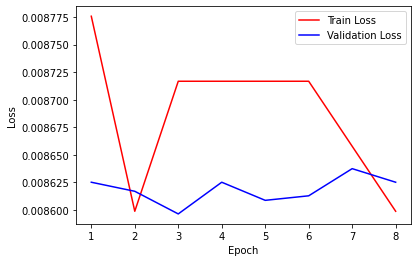

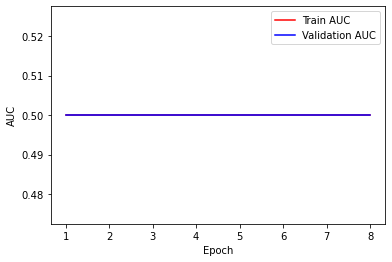

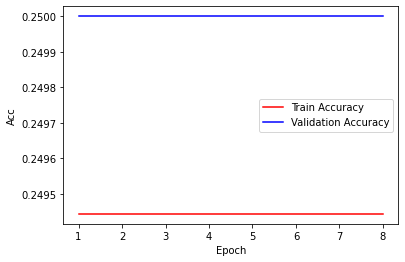

       target  pred
0           0     1
1           1     1
2           0     1
3           1     1
4           1     1
...       ...   ...
17113       0     1
17114       0     1
17115       0     1
17116       0     1
17117       0     1

[17118 rows x 2 columns]
AUC:  0.5
MCC:  0.0


C:\Users\dayad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


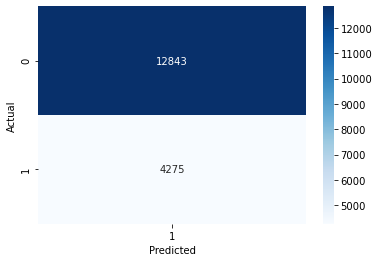

AUC: 0.500
12843


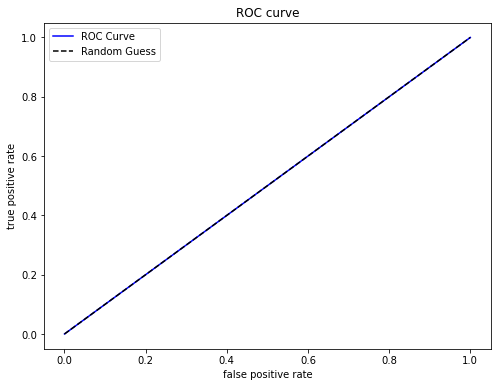

In [11]:

###############################
###    CNN+RNN (thesis)     ###
###############################

if CNN_RNN:
    
    #-------- Initials --------#
    
    # All features

    features = list(range(data_list_enc[0][0].shape[1]))
    residues = list(range(420))
    input_size = len(residues)
    num_classes = 1
    learning_rate = 0.001
    bat_size = 128
    epochs = 100
    n_features = len(features)
    criterion = nn.BCEWithLogitsLoss()
    
    
    # Initialize network
    net = Net_project(num_classes=num_classes, 
             n_features=n_features, 
             numHN=numHN, 
             numFilter=numFilter,
             dropOutRate=dropOutRate).to(device)
    
    optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                           weight_decay=0.0005,
                           amsgrad=True,)
    
    
    #-------- nested crossvalidation --------#
    
    test_preds = []
    test_targs = []
    test_loss = []
    for outer_k in range(data_partitions):
        
        print(f"k_outer: {outer_k}")

        X_test = data_list_enc[outer_k]
        y_test = target_list[outer_k]
        
        for inner_k in range(data_partitions):

            train_idx = []
            
            if inner_k != outer_k:
                c_in = 0
                print("\tval: " + str(inner_k))
   
                X_valid = data_list_enc[inner_k]
                y_valid = target_list[inner_k]


                for train_k in range(data_partitions):
                    if train_k != inner_k and train_k != outer_k:
                        train_idx.append(train_k)

                print("\ttrain:", str(train_idx))

                X_train = np.concatenate((data_list_enc[train_idx[0]], data_list_enc[train_idx[1]]))
                y_train = np.concatenate((target_list[train_idx[0]], target_list[train_idx[1]]))            

                train_ds = []
                for i in range(len(X_train)):
                    train_ds.append([np.transpose(X_train[i][:, features]), y_train[i]])

                val_ds = []
                for i in range(len(X_valid)):
                    val_ds.append([np.transpose(X_valid[i][:, features]), y_valid[i]])

                train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=bat_size, shuffle=True)
                val_ldr = torch.utils.data.DataLoader(val_ds, batch_size=bat_size, shuffle=True)

                train_acc, train_losses, train_auc, valid_acc, valid_losses, valid_auc, val_preds, val_targs = func.train_project(net, optimizer, train_ldr, val_ldr, [], X_valid, epochs, criterion)

                    #confirm this part works
                with torch.no_grad():
                    for batch_idx, (data, target) in enumerate(val_ldr):  ###
                        x_batch_val = data.float().detach()
                        y_batch_val = target.float().detach().unsqueeze(1)

                        output = net(x_batch_val)

                        val_batch_loss = criterion(output, y_batch_val)

                        preds = np.round(output.detach())
                        test_preds += list(preds.data.numpy().flatten())
                        test_targs += list(np.array(y_batch_val))
                        #test_loss += val_batch_loss.detach()

    #-------- Performance --------#
    epoch = np.arange(1,len(train_losses)+1)
    plt.figure()
    plt.plot(epoch, train_losses, 'r', epoch, valid_losses, 'b')
    plt.legend(['Train Loss','Validation Loss'])
    plt.xlabel('Epoch'), plt.ylabel('Loss')

    epoch = np.arange(1,len(train_auc)+1)
    plt.figure()
    plt.plot(epoch, train_auc, 'r', epoch, valid_auc, 'b')
    plt.legend(['Train AUC','Validation AUC'])
    plt.xlabel('Epoch'), plt.ylabel('AUC')

    epoch = np.arange(1,len(train_acc)+1)
    plt.figure()
    plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
    plt.legend(['Train Accuracy','Validation Accuracy'])
    plt.xlabel('Epoch'), plt.ylabel('Acc')
    plt.show()

    
    #-------- Save results --------#

    results = pd.DataFrame(list(zip( (int(x) for x in test_targs), (int(x) for x in test_preds))),columns =['target', 'pred'])
    print(results)

    try:
        os.mkdir('../results/')
    except:
        pass
    
    results.to_csv('../results/df_targets_preds_th_emb-{}_HN-{}_filter-{}_dr-{}_enery-{}.csv'.format(embedding, numHN, numFilter, dropOutRate, keep_energy), index=False)
    
    
    #-------- Performance Evaluation --------#
    # The results change every time we train, we should check why (maybe we missed something or did wrong with the seeds?)

    print("AUC: ", roc_auc_score(results['target'], results['pred']))
    print("MCC: ", matthews_corrcoef(results['target'], results['pred']))

    confusion_matrix = pd.crosstab(results['target'], results['pred'], rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.show()
    
    # Plot roc curve

    fpr, tpr, thres = roc_curve(results['target'], results['pred'])
    print('AUC: {:.3f}'.format(roc_auc_score(results['target'], results['pred'])))

    print( len([i for i, (a, b) in enumerate(zip(results['pred'], results['target'])) if a != b]))
    
    plt.figure(figsize=(8,6))

    # roc curve
    plt.plot(fpr, tpr, "b", label='ROC Curve')
    plt.plot([0,1],[0,1], "k--", label='Random Guess')
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve")

    try:
        os.mkdir('../results/plots/')
    except:
        pass
    plt.savefig('../results/plots/emb-{}_HN-{}_filter-{}_dr-{}_enery-{}_ROC.png'.format(embedding, numHN, numFilter, dropOutRate, keep_energy))

    plt.show()


In [12]:
#metrics
AUC = roc_auc_score(results['target'], results['pred'])
MCC = matthews_corrcoef(results['target'], results['pred'])
print("AUC: ", AUC)
print("MCC: ", MCC)

AUC:  0.5
MCC:  0.0


C:\Users\dayad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [13]:
#storing values
with mlflow.start_run():
    mlflow.log_param('embedding', embedding) 
    mlflow.log_param('Hidden Neurons', numHN)
    mlflow.log_param('filters CNN', numFilter)
    mlflow.log_param('Dropout rate', dropOutRate)
    mlflow.log_metric('AUC', AUC)
    mlflow.log_metric('MCC', MCC)
    #ADD ARTIFACTS (PLOTS)